# 4.0 Modeling

## 4.1 ARIMA (Autoregressive integrated moving average)

ARIMA stands for Autoregressive Integrated Moving Average Model. It belongs to a class of models that explains a given time series based on its own past values -i.e.- its own lags and the lagged forecast errors. The equation can be used to forecast future values. Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

So, ARIMA, short for AutoRegressive Integrated Moving Average, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.
ARIMA Models are specified by three order parameters: (p, d, q),

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

AR(p) Autoregression – a regression model that utilizes the dependent relationship between a current observation and observations over a previous period. An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series.

I(d) Integration – uses differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times.

MA(q) Moving Average – a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.

Types of ARIMA Model

ARIMA : Non-seasonal Autoregressive Integrated Moving Averages
SARIMA : Seasonal ARIMA
SARIMAX : Seasonal ARIMA with exogenous variables

If a time series, has seasonal patterns, then we need to add seasonal terms and it becomes SARIMA, short for Seasonal ARIMA.

3. The meaning of p, d and q in ARIMA model 

3.1 The meaning of p
p is the order of the Auto Regressive (AR) term. It refers to the number of lags of Y to be used as predictors.

3.2 The meaning of d
The term Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as we know, work best when the predictors are not correlated and are independent of each other. So we need to make the time series stationary.

The most common approach to make the series stationary is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.
The value of d, therefore, is the minimum number of differencing needed to make the series stationary. If the time series is already stationary, then d = 0.

3.3 The meaning of q
q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

## 4.2 SARIMA

A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA models we have seen so far. It is written as follows:

![alt text](pic6.png)

Where m = number of observations per year. We use uppercase notation for the seasonal parts of the model, and lowercase notation for the non-seasonal parts of the model. The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period.


## 4.3 LightGBM

- Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm
- It splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. 
- Leaf wise splits lead to increase in complexity and may lead to overfitting but it can be overcome by specifying another parameter max-depth which specifies the depth to which splitting will occur.
- LightGBM uses a novel technique of Gradient-based One-Side Sampling (GOSS) which downsamples the instances on the basis of gradients to filter out the data instances for finding a split GOSS.

![alt text](pic5.png)

## 4.4 Long Short Term Memory (LSTM)

Long Short Term Memory networks are a special kind of RNN, capable of learning long-term dependencies. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior.

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

![alt text](pic7.png)

## 4.5 Neural Prophet


NeuralProphet is an upgraded version of Prophet that is built using PyTorch and uses deep learning models such as AR-Net for time-series forecasting. The main benefit of using NeuralProphet is that it features a simple API inspired by Prophet, but gives you access to more sophisticated deep learning models for time-series forecasting.

![alt text](pic8.png)

In [ ]:
!pip install hyperopt

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import random
from itertools import cycle, islice
import statsmodels.api as sm
from pylab import rcParams

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.stattools import adfuller
from numpy import log
import numpy as np, pandas as pd
from numpy import sqrt,mean,log,diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
from lightgbm import LGBMRegressor as lgb
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score



from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
calendar = pd.read_csv("calendar.csv")
sell_df = pd.read_csv("sell_prices.csv")
train_val_df = pd.read_csv("sales_train_validation.csv")
train_eval_df = pd.read_csv("sales_train_evaluation.csv")
sub_df = pd.read_csv("sample_submission.csv")

How to find the order of differencing (d) in ARIMA model 

As stated earlier, the purpose of differencing is to make the time series stationary. But we should be careful to not over-difference the series. An over differenced series may still be stationary, which in turn will affect the model parameters.
So we should determine the right order of differencing. The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

If we can’t really decide between two orders of differencing, then we go with the order that gives the least standard deviation in the differenced series.

Now, we will explain these concepts with the help of an example as follows:-
First, I will check if the series is stationary using the Augmented Dickey Fuller test (ADF Test), from the statsmodels package. The reason being is that we need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

The null hypothesis (Ho) of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary.
So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.


In [ ]:
train_val_df.shape


In [4]:
# memory usage reduction
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

In [5]:
train_sales = downcast(train_val_df)

In [6]:
grid_df = pd.melt(train_sales, 
                  id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                  var_name = 'd', 
                  value_name = "sales")

In [7]:
calender_new = calendar[['date', 'wm_yr_wk', 'd', 'snap_CA', 'snap_TX', 'snap_WI', 'event_name_1','event_type_1', 'event_name_2','event_type_2']]
calender_new.head()

,date,wm_yr_wk,d,snap_CA,snap_TX,snap_WI,event_name_1,event_type_1,event_name_2,event_type_2
0,2011-01-29,11101,d_1,0,0,0,NaN,NaN,NaN,NaN
1,2011-01-30,11101,d_2,0,0,0,NaN,NaN,NaN,NaN
2,2011-01-31,11101,d_3,0,0,0,NaN,NaN,NaN,NaN
3,2011-02-01,11101,d_4,1,1,0,NaN,NaN,NaN,NaN
4,2011-02-02,11101,d_5,1,0,1,NaN,NaN,NaN,NaN


In [8]:
calender_new = calender_new.replace(np.nan, "None")

In [9]:
#Merging the melted dataframe with calender dataframe
master_df1 = pd.merge(grid_df,calender_new, on = "d")
master_df1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,snap_CA,snap_TX,snap_WI,event_name_1,event_type_1,event_name_2,event_type_2
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,0,0,0,None,None,None,None
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,0,0,0,None,None,None,None
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,0,0,0,None,None,None,None
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,0,0,0,None,None,None,None
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,0,0,0,None,None,None,None


In [10]:
# #Merging the previously obtained merged dataframe with sell dataframe
# master_df2 = pd.merge(master_df1,sell_df, on = ["store_id","item_id","wm_yr_wk"])
# master_df2.head()

In [11]:
from sklearn.preprocessing import LabelEncoder
label_enc = master_df1[['state_id','item_id','dept_id','cat_id','store_id','event_name_1','event_type_1', 'event_name_2','event_type_2']]

# LabelEncoder
le = LabelEncoder()

# apply "le.fit_transform"
df_encoded = label_enc.apply(le.fit_transform)

In [12]:
master_df1 = master_df1.drop(['state_id','item_id','dept_id','cat_id','store_id','event_name_1','event_type_1', 'event_name_2','event_type_2'], axis = 1)

In [13]:
master_df = pd.concat([master_df1, df_encoded], axis=1)

In [14]:
master_df = master_df.drop(['wm_yr_wk', 'd'], axis = 1)

In [15]:
#Saving the Dataframe to start modeling
master_df.to_pickle("master_df.pkl")

In [16]:
master_df = pd.read_pickle("master_df.pkl")

In [17]:
master_df.shape

(58327370, 15)

### Select the product you want to forecast for 

In [25]:
def select_product(master_df, product_id):
    prod = master_df[master_df['id'] == product_id].reset_index()
    return prod

In [26]:
#Adfuller test on one of the product

def adfuller_test(prod):
    result = adfuller(prod['sales'], autolag='AIC' )
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.


### Differencing and autocorrelation

In [27]:
def check_differencing(N, prod):
    '''
    N is the order of differencing
    
    '''
    plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':100})
    sales = prod['sales']
    
    # Original Series
    fig, axes = plt.subplots(N, 2, sharex=True)
    
    for i in range(N):
        
        if i == 0:
            axes[0, 0].plot(sales); axes[0, 0].set_title('Original Series')
            plot_acf((sales), ax=axes[0, 1])
            sales_new = sales
        else:
            sales_new = sales_new.diff()
            # 1st Differencing
            axes[i, 0].plot(sales_new); axes[i, 0].set_title('{}-Order Differencing'.format(i))
            plot_acf(sales_new.dropna(), ax=axes[i, 1])
    plt.show()

In [28]:
def check_partialacf(N, prod):
    '''
    N is the order of differencing
    
    '''
    plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':100})
    sales = prod['sales']
    
    # Original Series
    fig, axes = plt.subplots(N, 2, sharex=True)
    
    for i in range(N):
        
        if i == 0:
            axes[0, 0].plot(sales); axes[0, 0].set_title('Original Series')
            plot_pacf((sales), ax=axes[0, 1])
            sales_new = sales
        else:
            sales_new = sales_new.diff()
            # 1st Differencing
            axes[i, 0].plot(sales_new); axes[i, 0].set_title('{}-Order Differencing'.format(i))
            plot_pacf(sales_new.dropna(), ax=axes[i, 1])
    plt.show()

In [29]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model

def arima_model(prod, order):
    train = prod['sales'][:1850]
    test = prod['sales'][1850:-1]
    model = ARIMA(train, order= order)
    model_fit = model.fit()
    print(model_fit.summary())

    # Forecast
    fc, se, conf = model_fit.forecast(62, alpha=0.01)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc,index= range(1850,1912,1))
    lower_series = pd.Series(conf[:, 0], index= range(1850,1912,1))
    upper_series = pd.Series(conf[:, 1], index= range(1850,1912,1))
    rmse = np.mean((fc_series - test)**2)**.5
    print("Model's RMSE: ", rmse)
    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train[1700:], label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [30]:
# # Accuracy metrics
# def forecast_accuracy(forecast, actual):
#     mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
#     me = np.mean(forecast - actual)             # ME
#     mae = np.mean(np.abs(forecast - actual))    # MAE
#     mpe = np.mean((forecast - actual)/actual)   # MPE
#     rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
#     return({'mape':mape, 'me':me, 'mae': mae, 
#             'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
#             'corr':corr, 'minmax':minmax})

# forecast_accuracy(fc, test.values)

In [38]:
prod = select_product(master_df, 'HOBBIES_1_005_CA_1_validation')

In [39]:
print(adfuller_test(prod))


ADF Statistic: -11.221129
p-value: 0.000000
None


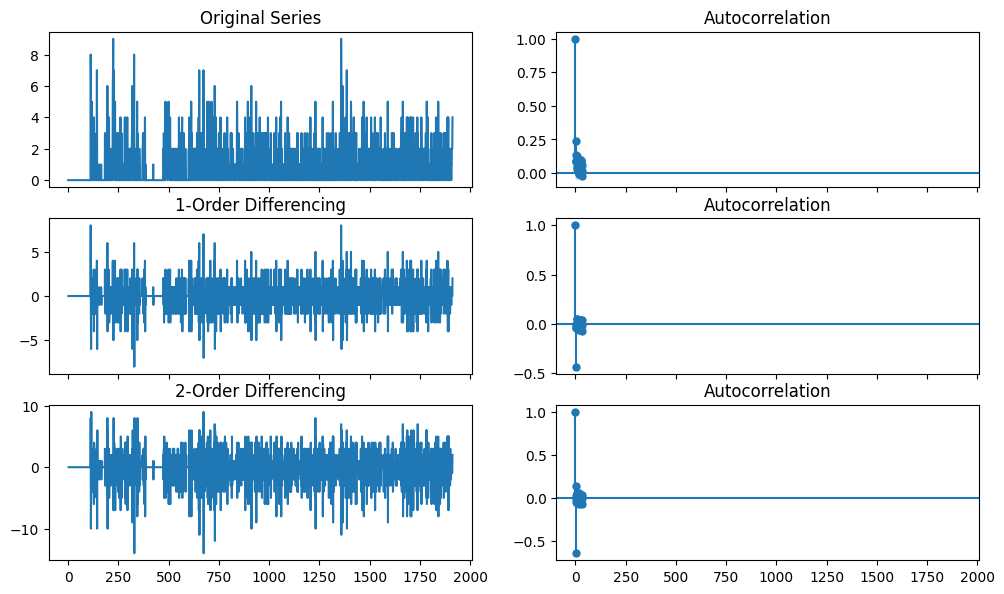

None


In [40]:
print(check_differencing(3, prod))

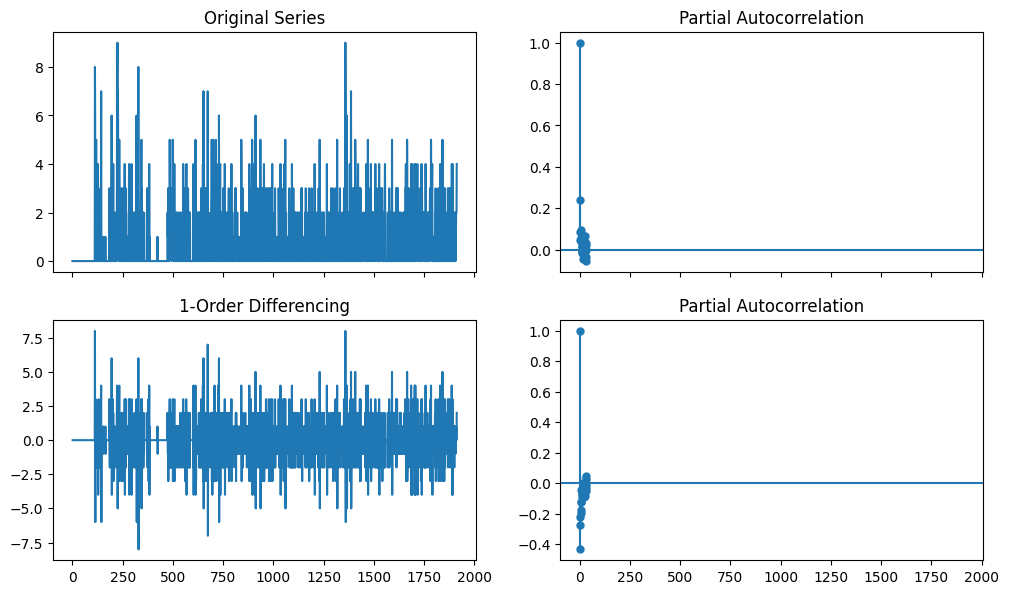

None


In [41]:
print(check_partialacf(2, prod))

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1849
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3035.542
Method:                       css-mle   S.D. of innovations              1.249
Date:                Mon, 28 Jun 2021   AIC                           6081.083
Time:                        19:44:53   BIC                           6108.695
Sample:                             1   HQIC                          6091.262
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.001      0.602      0.547      -0.001       0.003
ar.L1.D.sales     0.1832      0.025      7.470      0.000       0.135       0.231
ar.L2.D.sales     0.0504      0.024     

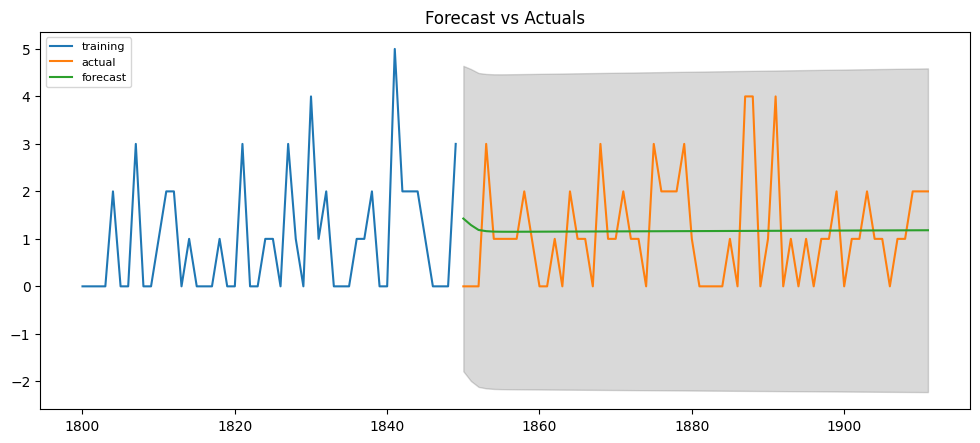

In [42]:
arima_model(prod, (2,1,1))

### AutoARIMA

In [49]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

def autoarima(prod):
    train = prod['sales'][:1850]
    test = prod['sales'][1850:]
    smodel = pm.auto_arima(train,start_p=1, start_q=1,
                             test='adf',
                             max_p=4, max_q=4, m=12,
                             start_P=0, seasonal=True,
                             d=None, D=0, trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

    print(smodel.summary())
    # Forecast

    n_periods = 62
    fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)

    # make series for plotting purpose 
    fitted_series = pd.Series(fitted, index= range(1850,1912,1))
    lower_series = pd.Series(confint[:, 0],index=range(1850,1912,1))
    upper_series = pd.Series(confint[:, 1],index=range(1850,1912,1))
    rmse = np.mean((fitted_series - test)**2)**.5
    print("Model's RMSE: ", rmse)
    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.title('Forecast vs Actuals')
    plt.plot(train[1700:], label = "training")
    plt.plot(test, label = "test")
    plt.plot(fitted_series, label = "forecast")
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.05)
    plt.legend()
    plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=6086.193, Time=1.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6221.491, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6113.521, Time=0.64 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6132.802, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7024.378, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=6085.755, Time=0.48 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=6086.198, Time=1.54 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=6088.869, Time=3.62 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=6130.822, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6111.540, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=6072.160, Time=1.05 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=6069.924, Time=4.49 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=6071.867, Time=10.37 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=6073.106, Time=4.70 sec
 ARIMA(2,0,1)(0,0,

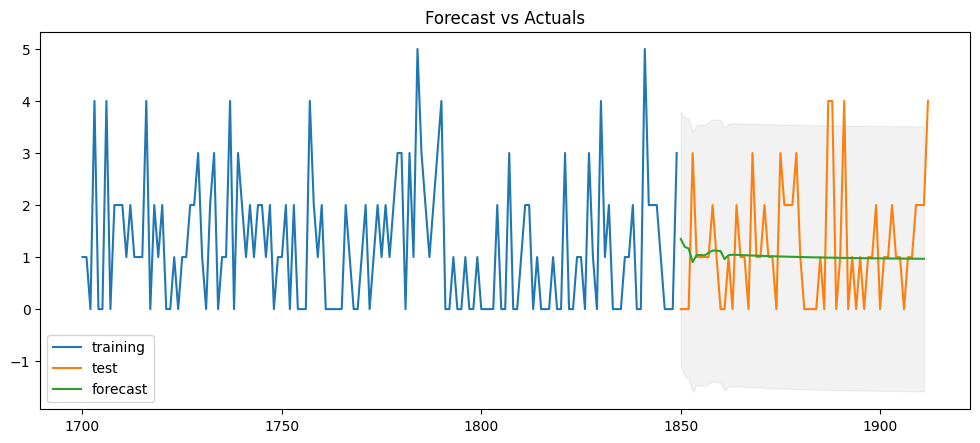

In [50]:
autoarima(prod)

In [55]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

def autoarima_differenced(prod_num):
    train = prod['sales'][:1850]
    test = prod['sales'][1850:]
    smodel = pm.auto_arima(train,start_p=1, start_q=1,
                             test='adf',
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=None, D=1, trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

    print(smodel.summary())
    # Forecast

    n_periods = 62
    fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)

    # make series for plotting purpose 
    fitted_series = pd.Series(fitted, index= range(1850,1912,1))
    lower_series = pd.Series(confint[:, 0],index=range(1850,1912,1))
    upper_series = pd.Series(confint[:, 1],index=range(1850,1912,1))
    rmse = np.mean((fitted_series - test)**2)**.5
    print("Model's RMSE: ", rmse)
    # Plot
    
    plt.plot(train[1800:], label = "training")
    plt.plot(test, label = "test")
    plt.plot(fitted_series, label = "forecast")
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.05)
    plt.legend()
    plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.17 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=7427.565, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=6792.523, Time=0.88 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.98 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=7425.612, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=7349.927, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=6592.651, Time=3.35 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=17.30 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.74 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=6676.298, Time=2.78 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=6589.150, Time=4.15 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=6790.602, Time=1.11 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=22.12 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.20 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=6589

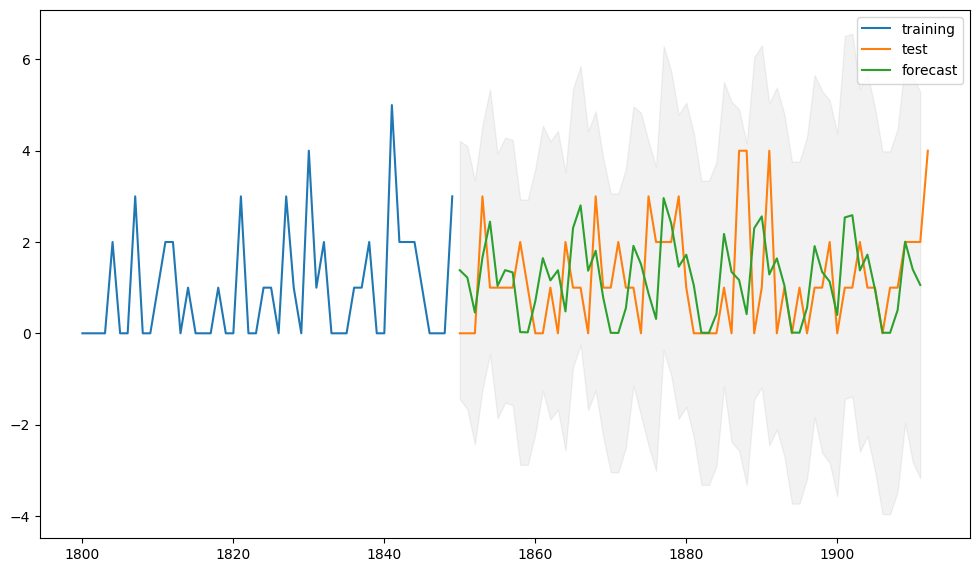

In [56]:
autoarima_differenced(prod)

In [57]:
smodel.plot_diagnostics(figsize=(10,8))
plt.show()

NameError: name 'smodel' is not defined

In [58]:
import gc
del master_df1, grid_df, calendar
gc.collect()

6663

### Seasonal ARIMA

In [59]:
master_df.head()

,id,sales,date,snap_CA,snap_TX,snap_WI,state_id,item_id,dept_id,cat_id,store_id,event_name_1,event_type_1,event_name_2,event_type_2
0,HOBBIES_1_001_CA_1_validation,0,2011-01-29,0,0,0,0,1437,3,1,0,19,2,3,1
1,HOBBIES_1_002_CA_1_validation,0,2011-01-29,0,0,0,0,1438,3,1,0,19,2,3,1
2,HOBBIES_1_003_CA_1_validation,0,2011-01-29,0,0,0,0,1439,3,1,0,19,2,3,1
3,HOBBIES_1_004_CA_1_validation,0,2011-01-29,0,0,0,0,1440,3,1,0,19,2,3,1
4,HOBBIES_1_005_CA_1_validation,0,2011-01-29,0,0,0,0,1441,3,1,0,19,2,3,1


In [ ]:
#Introduce lags
lags = [1,2,3,6,12,28]
for lag in lags:
    master_df['sales_lag_'+str(lag)] = master_df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sales'].shift(lag).astype(np.float16)

In [ ]:
master_df['iteam_sold_avg'] = master_df.groupby('item_id')['sales'].transform('mean').astype(np.float16)
master_df['state_sold_avg'] = master_df.groupby('state_id')['sales'].transform('mean').astype(np.float16)
master_df['store_sold_avg'] = master_df.groupby('store_id')['sales'].transform('mean').astype(np.float16)
master_df['cat_sold_avg'] = master_df.groupby('cat_id')['sales'].transform('mean').astype(np.float16)
master_df['dept_sold_avg'] = master_df.groupby('dept_id')['sales'].transform('mean').astype(np.float16)

In [ ]:
master_df['cat_dept_sold_avg'] = master_df.groupby(['cat_id','dept_id'])['sales'].transform('mean').astype(np.float16)
master_df['store_item_sold_avg'] = master_df.groupby(['store_id','item_id'])['sales'].transform('mean').astype(np.float16)
master_df['cat_item_sold_avg'] = master_df.groupby(['cat_id','item_id'])['sales'].transform('mean').astype(np.float16)
master_df['dept_item_sold_avg'] = master_df.groupby(['dept_id','item_id'])['sales'].transform('mean').astype(np.float16)
master_df['state_store_sold_avg'] = master_df.groupby(['state_id','store_id'])['sales'].transform('mean').astype(np.float16)
master_df['state_store_cat_sold_avg'] = master_df.groupby(['state_id','store_id','cat_id'])['sales'].transform('mean').astype(np.float16)
master_df['store_cat_dept_sold_avg'] = master_df.groupby(['store_id','cat_id','dept_id'])['sales'].transform('mean').astype(np.float16)

In [ ]:
master_df['rolling_sales_mean'] = master_df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sales'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

In [ ]:
master_df['expanding_sold_mean'] = master_df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sales'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

In [ ]:
for col in master_df.columns:
    if master_df[col].isnull().sum() > 0:
        master_df[col] = master_df[col].fillna(0)

In [60]:
def sarimax_model(prod, order, seasonal_order, seasonal_variables):
    exog_train = prod[seasonal_variables].iloc[:1850, :]
    exog_test = prod[seasonal_variables].iloc[1850:, :]
    
    mod = sm.tsa.statespace.SARIMAX(prod.sales[:1850],trend='t', exog=exog_train, order= order, seasonal_order=seasonal_order)
    results = mod.fit() 
    rmse = np.mean((results.predict(start = 1850, end = 1912, exog=exog_test) - prod.sales[1850:])**2)**.5
    print("Model's RMSE: ", rmse)
    plt.figure(figsize= (18,6))
    results.summary()
    plt.plot(prod.sales[1850:], label = "actual")
    plt.plot(results.predict(start = 1850, end = 1912, exog=exog_test), label = 'Predicted')
    plt.legend()
    plt.show()
    

Model's RMSE:  1.1943374158638083


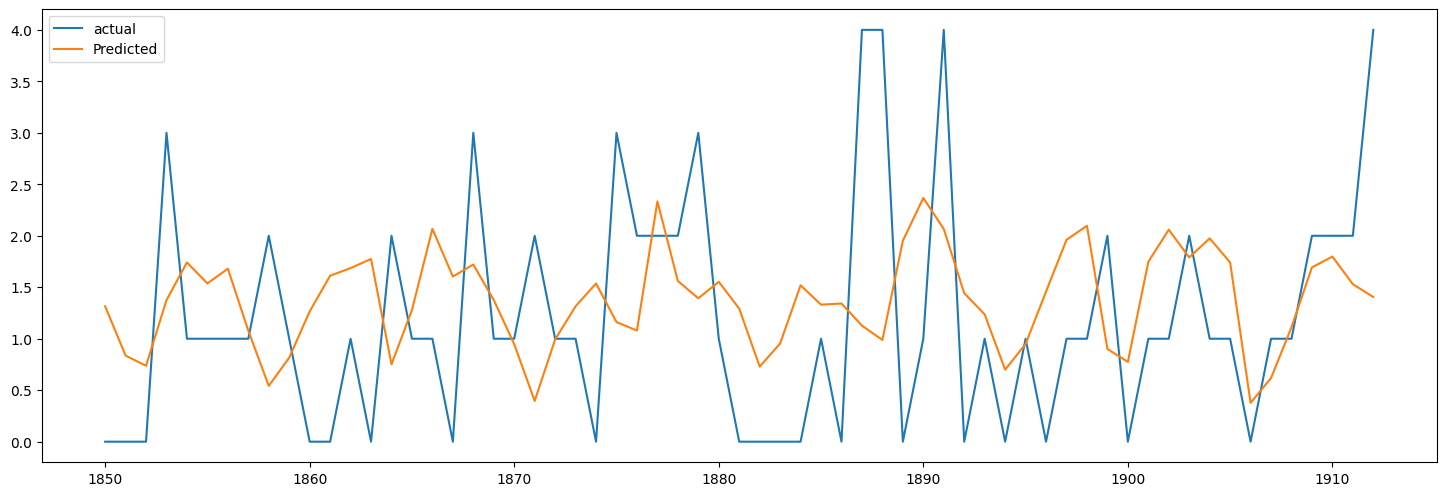

In [62]:
seasonal_variables = ['day','snap_CA', 'event_name_1']
prod = select_product(master_df, 'HOBBIES_1_005_CA_1_validation')
prod['date'] = pd.to_datetime(prod['date'])
prod['month'] = prod['date'].dt.month
prod['day'] = prod['date'].dt.dayofweek
prod['year'] = prod['date'].dt.year

In [ ]:
sarimax_model(prod, (2,1,2), (2, 1, 2, 12), seasonal_variables)

Model's RMSE:  1.264001228223515


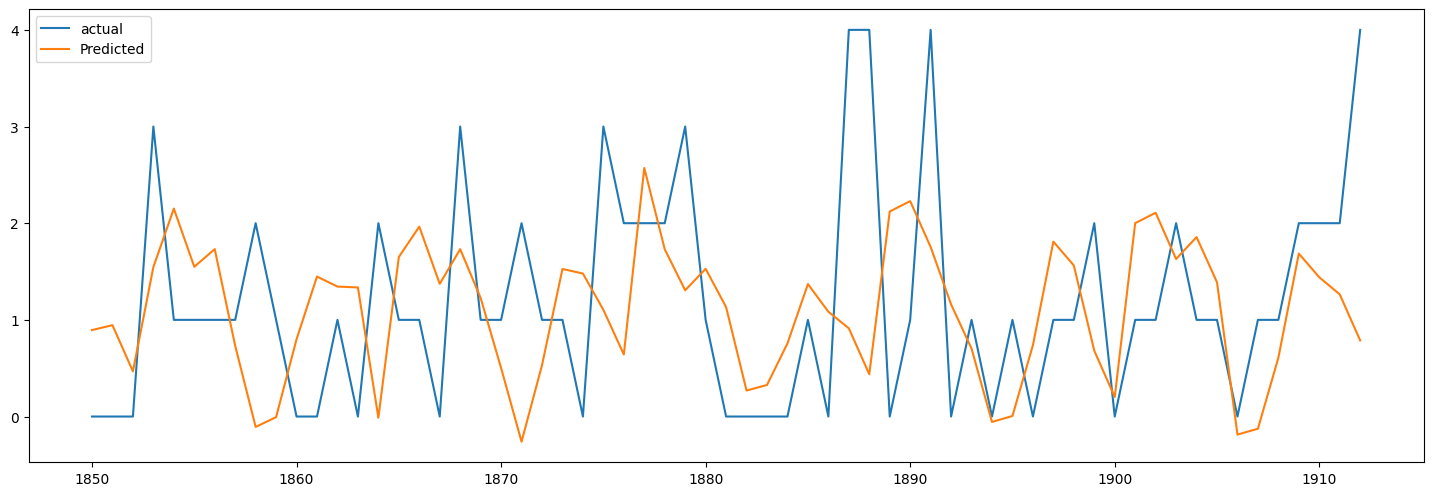

In [71]:
sarimax_model(prod, (2,0,1), (2, 1, 1, 12), seasonal_variables)  

### LightGBM

In [75]:
prod = select_product(master_df, 'HOBBIES_1_005_CA_1_validation')

In [88]:
def traintestsplit(prod):
    prod['date'] = pd.to_datetime(prod['date'])
    prod['month'] = prod['date'].dt.month
    prod['day'] = prod['date'].dt.dayofweek
    prod['year'] = prod['date'].dt.year
    target = prod['sales']
    prod = prod.drop(['index',"sales"], axis = 1)
    
    train_x, test_x, train_y, test_y = train_test_split(prod,target, test_size=0.05, random_state=2018)
    train_x = train_x.drop(['item_id','dept_id','cat_id','store_id',"id","date"], axis =1)
    test_x = test_x.drop(['item_id','dept_id','cat_id','store_id', "id","date"], axis =1)
    
    return train_x, test_x, train_y, test_y

In [80]:
train_x, test_x, train_y, test_y= traintestsplit(prod)

In [82]:
valgrid = {'n_estimators':hp.quniform('n_estimators', 900, 1200, 100),
           'learning_rate':hp.quniform('learning_rate', 0.1, 0.4, 0.01),
           'max_depth':hp.quniform('max_depth', 4,8,1),
           'num_leaves':hp.quniform('num_leaves', 25,75,50),
           'subsample':hp.quniform('subsample', 0.5, 0.9, 0.1),
           'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 0.9, 0.1),
           'min_child_weight':hp.quniform('min_child_weight', 200, 500, 100) 
          }

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
              'learning_rate': params['learning_rate'],
              'max_depth': int(params['max_depth']),
              'num_leaves': int(params['num_leaves']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'min_child_weight': params['min_child_weight']}
    
    lgb_a = lgb(**params)
    score = cross_val_score(lgb_a, train_x, train_y, cv=2, n_jobs=-1).mean()
    return score

100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.05trial/s, best loss: -0.0003560326048313023]


In [83]:
import lightgbm

def prediction(bestP, train_x, test_x, train_y, test_y):
    
    model = lightgbm.LGBMRegressor(
            n_estimators = int(bestP['n_estimators']),
            learning_rate = bestP['learning_rate'],
            subsample = bestP['subsample'],
            colsample_bytree = bestP['colsample_bytree'],
            max_depth = int(bestP['max_depth']),
            num_leaves = int(bestP['num_leaves']),
            min_child_weight = int(bestP['min_child_weight']))


    model.fit(train_x, train_y, eval_set=[(train_x,train_y),(test_x,test_y)], eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    pred = model.predict(test_x)
    return pred

In [90]:
def create_plot(test_y, pred):
    plt.figure(figsize= (18,6))
    test_y = test_y.reset_index()
    plt.plot(test_y.sales, label = 'actual')
    plt.plot(pred, label = 'Predicted')
    plt.legend()
    plt.show()

100%|███████████████████████████████████████████| 100/100 [00:14<00:00,  6.81trial/s, best loss: -8.81260700130726e-05]
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.24874	training's l2: 1.55936	valid_1's rmse: 1.24673	valid_1's l2: 1.55433
[40]	training's rmse: 1.24498	training's l2: 1.54998	valid_1's rmse: 1.24614	valid_1's l2: 1.55286
Early stopping, best iteration is:
[30]	training's rmse: 1.24613	training's l2: 1.55285	valid_1's rmse: 1.24504	valid_1's l2: 1.55013


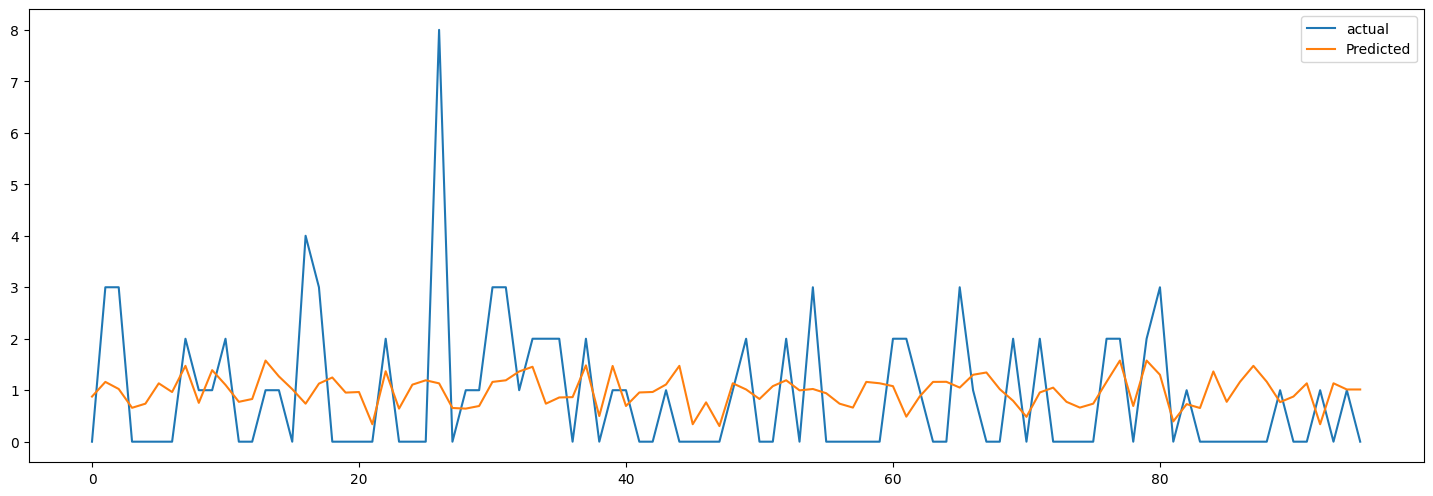

In [91]:
prod = select_product(master_df, 'HOBBIES_1_005_CA_1_validation')
train_x, test_x, train_y, test_y= traintestsplit(prod)
bestP = fmin(fn= objective, space= valgrid, max_evals=100, rstate=np.random.RandomState(123), algo=tpe.suggest)
pred = prediction(bestP,train_x, test_x, train_y, test_y)
create_plot(test_y, pred)